## Load Data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc as sk_auc, precision_recall_curve  # Burada sk_auc dedik
import pandas as pd
import kagglehub

CIC_path = kagglehub.dataset_download("dhoogla/nf-cse-cic-ids2018")

try:
    # Read only the first 5 rows to save memory/time for now
    CIC_df = pd.read_parquet(CIC_path)
    print("Successfully loaded sample data:")
    print(CIC_df.columns.tolist())
    display(CIC_df.head())
except FileNotFoundError:
    print(f"Error: Could not find file in {CIC_path}")

100%|██████████| 50.6M/50.6M [00:03<00:00, 15.6MB/s]

Extracting files...


Successfully loaded sample data:
['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,51128,443,6,91.000000,152,0,3,0,194,4285680,0,Benign
1,443,51036,6,91.178001,994,979,7,7,24,4234714,0,Benign
2,12262,445,6,0.000000,585,344,5,4,30,4294106,0,Benign
3,61023,53,17,0.000000,136,168,2,2,0,4293985,0,Benign
4,443,51037,6,91.178001,72,40,1,1,24,4294845,0,Benign


In [2]:
import pandas as pd
import kagglehub

NB15_path = kagglehub.dataset_download("dhoogla/nfunswnb15")

try:
    # Read only the first 5 rows to save memory/time for now
    NB15_df = pd.read_parquet(NB15_path)
    print("Successfully loaded sample data:")
    print(NB15_df.columns.tolist())
    display(NB15_df.head())
except FileNotFoundError:
    print(f"Error: Could not find file in {NB15_path}")

100%|██████████| 14.5M/14.5M [00:01<00:00, 8.76MB/s]

Extracting files...


Successfully loaded sample data:
['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,62073,56082,6,0.0,9672,416,11,8,25,15,0,Benign
1,32284,1526,6,0.0,1776,104,6,2,25,0,0,Benign
2,21,21971,6,1.0,1842,1236,26,22,25,1111,0,Benign
3,23800,46893,6,0.0,528,8824,10,12,27,124,0,Benign
4,63062,21,6,1.0,1786,2340,32,34,25,1459,0,Benign


## Data preprocessing

#### Feature Selection

In [3]:
target_features = [
        'PROTOCOL', 'TCP_FLAGS', 'L7_PROTO', 'IN_BYTES',
        'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'FLOW_DURATION_MILLISECONDS',
        'Label'
    ]

In [4]:
CIC_df = CIC_df[target_features]
NB15_df = NB15_df[target_features]

In [5]:
NB15_df

,PROTOCOL,TCP_FLAGS,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,FLOW_DURATION_MILLISECONDS,Label
0,6,25,0.0,9672,416,11,8,15,0
1,6,25,0.0,1776,104,6,2,0,0
2,6,25,1.0,1842,1236,26,22,1111,0
3,6,27,0.0,528,8824,10,12,124,0
4,6,25,1.0,1786,2340,32,34,1459,0
...,...,...,...,...,...,...,...,...,...
1484206,6,26,0.0,1218,456,10,6,0,0
1484207,6,26,1.0,2044,2404,36,34,0,0
1484208,6,27,0.0,320,1918,6,8,0,0
1484209,6,27,0.0,528,8824,10,12,0,0


#### Data Celaning

In [6]:
CIC_df.dropna(inplace=True)
NB15_df.dropna(inplace=True)

CIC_df.drop_duplicates(inplace=True)
NB15_df.drop_duplicates(inplace=True)


print(f"CIC dataset cleaned length: {len(CIC_df)}")
print(f"NB15 dataset cleaned length: {len(NB15_df)}")

CIC dataset cleaned length: 1714024
NB15 dataset cleaned length: 321191


In [7]:
CIC_df["Label"].value_counts()

,count
Label,
0,1610280
1,103744


In [8]:
NB15_df["Label"].value_counts()

,count
Label,
0,273554
1,47637


#### Normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
  scaler = MinMaxScaler()
  feature_cols = [c for c in df.columns if c != 'Label']
  df[feature_cols] = scaler.fit_transform(df[feature_cols])

  return df

#### Data Split

%80 train

%20 test

In [10]:
from sklearn.model_selection import train_test_split

def split_data(df):
  feature_cols = [c for c in df.columns if c != 'Label']

  X = df[feature_cols].values
  y = df['Label'].values

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.20, random_state=42, stratify=y
  )

  print(f"Final Train Shape: {X_train.shape}")
  print(f"Final Test Shape: {X_test.shape}")

  return X_train, X_test, y_train, y_test

In [11]:
datasets = {}

datasets['CIC'] = split_data(normalize_data(CIC_df))
datasets['UNSW'] = split_data(normalize_data(NB15_df))

Final Train Shape: (1371219, 8)
Final Test Shape: (342805, 8)
Final Train Shape: (256952, 8)
Final Test Shape: (64239, 8)


## Model Architecture

#### Custom PyTorch datasets

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class NetFlowDataset(Dataset):
    def __init__(self, X, y):
        # Input shape needs to be (Batch, Channels, Length) for Conv1d
        # We reshape features from (Batch, 8) to (Batch, 1, 8)
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_dataloaders(X_train, X_test, y_train, y_test, batch_size=64):
    train_ds = NetFlowDataset(X_train, y_train)
    test_ds = NetFlowDataset(X_test, y_test)

    # Num_workers=0 is safer for Colab to avoid multiprocessing issues
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader

#### CNN-GRU Model and Evaluation

In [13]:
class CNN_GRU_IDS(nn.Module):
    def __init__(self):
        super(CNN_GRU_IDS, self).__init__()

        # Spatial Feature Extraction (CNN)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.relu = nn.ReLU()

        # Pooling & Normalization
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.batch_norm = nn.BatchNorm1d(64)

        # Temporal Feature Extraction (GRU)
        self.gru = nn.GRU(input_size=64, hidden_size=128, batch_first=True)

        # Classification Head
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, 2) # Binary: 0=Benign, 1=Attack

    def forward(self, x):
        # 1. CNN Phase
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.batch_norm(x)

        # 2. Reshape for GRU
        x = x.permute(0, 2, 1)

        # 3. GRU Phase
        _, h_n = self.gru(x)
        x = h_n.squeeze(0)

        # 4. Dense Phase
        x = self.dropout(x)
        x = self.fc(x)
        return x


Using device: cuda

[Training] Starting training for CIC on cuda...
  Epoch 1/50 | Train Loss: 0.0142 | Val Loss: 0.0134
  Epoch 2/50 | Train Loss: 0.0136 | Val Loss: 0.0134
  Epoch 3/50 | Train Loss: 0.0135 | Val Loss: 0.0137
  Epoch 4/50 | Train Loss: 0.0135 | Val Loss: 0.1208
  Epoch 5/50 | Train Loss: 0.0134 | Val Loss: 0.0132
  Epoch 6/50 | Train Loss: 0.0135 | Val Loss: 0.0133
  Epoch 7/50 | Train Loss: 0.0134 | Val Loss: 0.0132
  Epoch 8/50 | Train Loss: 0.0134 | Val Loss: 0.0132
  Epoch 9/50 | Train Loss: 0.0133 | Val Loss: 0.0129
  Epoch 10/50 | Train Loss: 0.0133 | Val Loss: 0.0131
  Epoch 11/50 | Train Loss: 0.0132 | Val Loss: 0.0129
  Epoch 12/50 | Train Loss: 0.0132 | Val Loss: 0.0129
  Epoch 13/50 | Train Loss: 0.0131 | Val Loss: 0.0163
  Epoch 14/50 | Train Loss: 0.0130 | Val Loss: 0.0129
  Epoch 15/50 | Train Loss: 0.0130 | Val Loss: 0.0129
  Epoch 16/50 | Train Loss: 0.0129 | Val Loss: 0.0126
  Epoch 17/50 | Train Loss: 0.0129 | Val Loss: 0.0126
  Epoch 18/50 | Train L

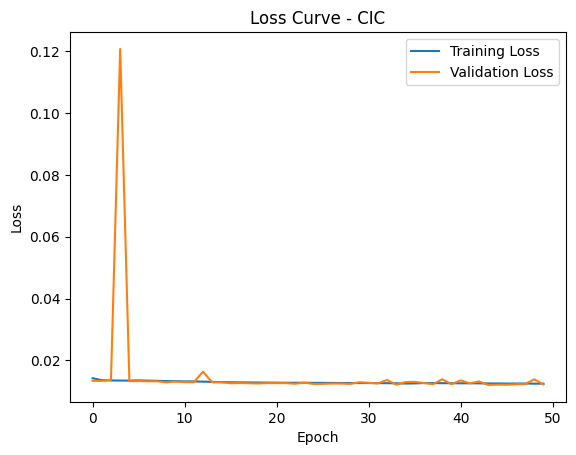

  Training Complete. Time: 3967.89s

--- Threshold (Karar Eşiği) Optimizasyonu ---
Threshold  Recall     Precision  F1-Score  
0.10       0.9992     0.0707     0.1320    
0.15       0.9951     0.0747     0.1389    
0.20       0.9793     0.1018     0.1845    
0.25       0.9211     0.1770     0.2970    
0.30       0.8763     0.2682     0.4107    
0.35       0.7789     0.6821     0.7273    
0.40       0.7557     0.8998     0.8215    
0.45       0.7528     0.9188     0.8275    
0.50       0.7524     0.9216     0.8284    
0.55       0.7519     0.9233     0.8289    

En iyi F1 Skoru için önerilen Threshold: 0.55

--- Results for CIC (Threshold 0.5) ---
  Accuracy:  98.11%
  Precision: 92.16%
  Recall:    75.24%
  F1 Score:  82.84%
  FAR:       0.0041
  AUC:       0.9445
  Inference Time: 7.60s
------------------------------


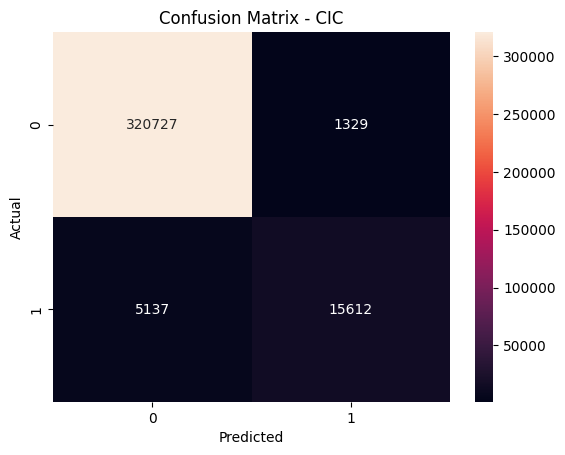

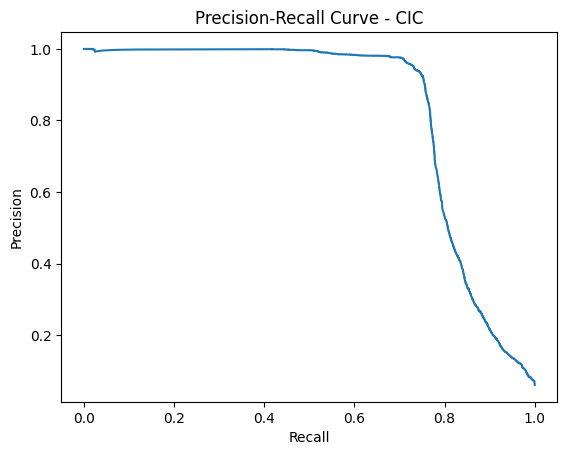

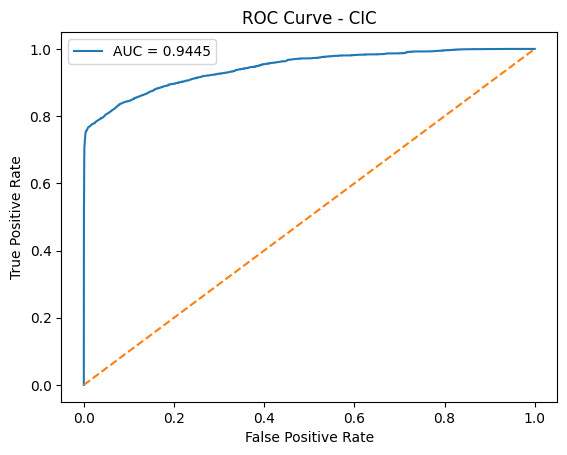


[Training] Starting training for UNSW on cuda...
  Epoch 1/50 | Train Loss: 0.0261 | Val Loss: 0.0309
  Epoch 2/50 | Train Loss: 0.0204 | Val Loss: 0.0182
  Epoch 3/50 | Train Loss: 0.0176 | Val Loss: 0.0166
  Epoch 4/50 | Train Loss: 0.0160 | Val Loss: 0.0156
  Epoch 5/50 | Train Loss: 0.0154 | Val Loss: 0.0145
  Epoch 6/50 | Train Loss: 0.0147 | Val Loss: 0.0147
  Epoch 7/50 | Train Loss: 0.0146 | Val Loss: 0.0137
  Epoch 8/50 | Train Loss: 0.0144 | Val Loss: 0.0136
  Epoch 9/50 | Train Loss: 0.0140 | Val Loss: 0.0135
  Epoch 10/50 | Train Loss: 0.0140 | Val Loss: 0.0136
  Epoch 11/50 | Train Loss: 0.0139 | Val Loss: 0.0150
  Epoch 12/50 | Train Loss: 0.0137 | Val Loss: 0.0134
  Epoch 13/50 | Train Loss: 0.0138 | Val Loss: 0.0147
  Epoch 14/50 | Train Loss: 0.0139 | Val Loss: 0.0131
  Epoch 15/50 | Train Loss: 0.0135 | Val Loss: 0.0132
  Epoch 16/50 | Train Loss: 0.0135 | Val Loss: 0.0130
  Epoch 17/50 | Train Loss: 0.0134 | Val Loss: 0.0129
  Epoch 18/50 | Train Loss: 0.0133 | Val 

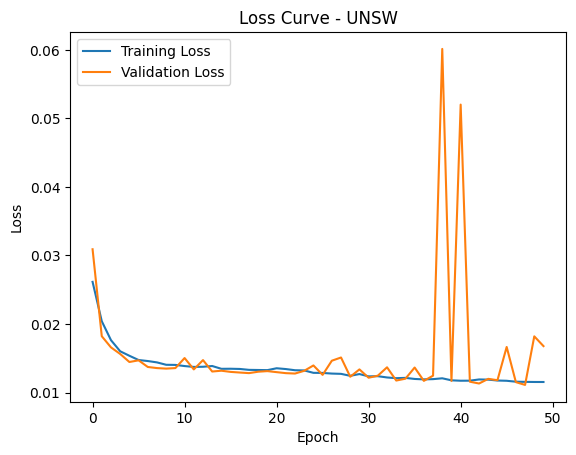

  Training Complete. Time: 746.35s

--- Threshold (Karar Eşiği) Optimizasyonu ---
Threshold  Recall     Precision  F1-Score  
0.10       0.9999     0.4973     0.6642    
0.15       0.9996     0.5862     0.7390    
0.20       0.9995     0.6149     0.7614    
0.25       0.9994     0.6239     0.7682    
0.30       0.9994     0.6315     0.7739    
0.35       0.9983     0.6479     0.7858    
0.40       0.9975     0.6561     0.7915    
0.45       0.9963     0.6615     0.7951    
0.50       0.9874     0.6809     0.8060    
0.55       0.9029     0.7799     0.8369    

En iyi F1 Skoru için önerilen Threshold: 0.55

--- Results for UNSW (Threshold 0.5) ---
  Accuracy:  92.95%
  Precision: 68.09%
  Recall:    98.74%
  F1 Score:  80.60%
  FAR:       0.0806
  AUC:       0.9860
  Inference Time: 1.42s
------------------------------


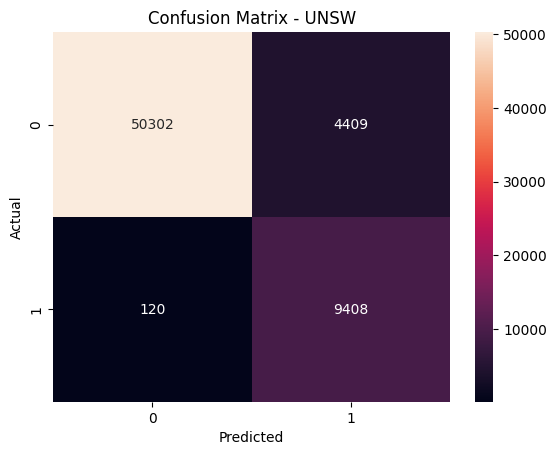

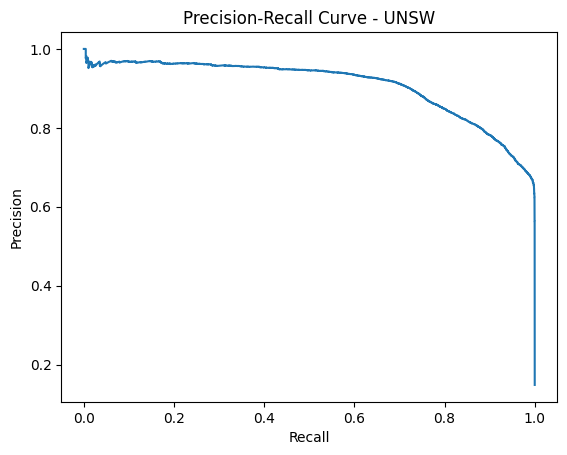

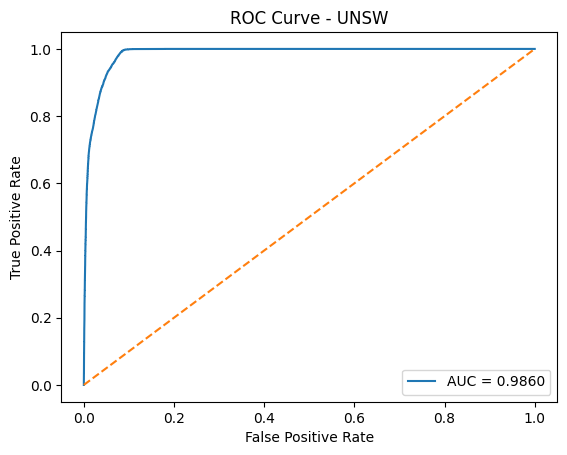

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import time
import copy
import numpy as np

# --- 1. FOCAL LOSS SINIFI ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean', device='cuda'):
        """
        alpha: Dengesizlik katsayısı (Attack sınıfı için ağırlık).
               0.75 demek; saldırı hatasına %75, normal hataya %25 önem ver demektir.
        gamma: Odaklanma katsayısı (Genelde 2.0).
               Kolay bilinen örneklerin etkisini azaltır, zorlara odaklar.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.device = device

    def forward(self, inputs, targets):
        # Cross Entropy Loss
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')

        # P_t (Tahmin olasılığı)
        pt = torch.exp(-BCE_loss)

        # Alpha ayarlaması
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha).to(self.device)

        # Focal Loss Formülü
        F_loss = alpha_t * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        else:
            return torch.sum(F_loss)

# --- 2. EARLY STOPPING SINIFI ---
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# --- 3. EĞİTİM FONKSİYONU ---
def train_model(model, train_loader, test_loader, dataset_name, device):
    print(f"\n[Training] Starting training for {dataset_name} on {device}...")

    # Focal Loss Kullanımı
    criterion = FocalLoss(alpha=0.75, gamma=2.0, device=device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses=[]
    val_losses=[]

    early_stopper = EarlyStopping(patience=10)
    train_start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)

        print(f"  Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Check Early Stopping
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print(f"  [Early Stopping] Triggered at epoch {epoch+1}")
            break
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"Loss Curve - {dataset_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    train_time = time.time() - train_start
    print(f"  Training Complete. Time: {train_time:.2f}s")

    # Load best weights
    model.load_state_dict(early_stopper.best_model_wts)
    return model, train_time

# --- 4. THRESHOLD BULMA FONKSİYONU (YENİ) ---
def find_best_threshold(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    # Olasılıkları topla
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Sınıf 1 (Saldırı) olasılıklarını al
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Farklı eşikleri dene (0.10'dan 0.60'a kadar)
    thresholds = np.arange(0.1, 0.6, 0.05)

    print("\n--- Threshold (Karar Eşiği) Optimizasyonu ---")
    print(f"{'Threshold':<10} {'Recall':<10} {'Precision':<10} {'F1-Score':<10}")

    best_f1 = 0
    best_thresh = 0.5

    for t in thresholds:
        preds = (np.array(all_probs) > t).astype(int)

        # Metrikleri hesapla
        rec = recall_score(all_labels, preds, zero_division=0)
        prec = precision_score(all_labels, preds, zero_division=0)
        f1 = f1_score(all_labels, preds, zero_division=0)

        print(f"{t:<10.2f} {rec:<10.4f} {prec:<10.4f} {f1:<10.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    print(f"\nEn iyi F1 Skoru için önerilen Threshold: {best_thresh:.2f}")
    return best_thresh

# --- 5. DEĞERLENDİRME FONKSİYONU ---
def evaluate_model(model, test_loader, dataset_name, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    inference_start = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    inference_time = time.time() - inference_start

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0

    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    far = fp / (fp + tn) if (fp + tn) > 0 else 0.0

    print(f"\n--- Results for {dataset_name} (Threshold 0.5) ---")
    print(f"  Accuracy:  {acc*100:.2f}%")
    print(f"  Precision: {prec*100:.2f}%")
    print(f"  Recall:    {rec*100:.2f}%")
    print(f"  F1 Score:  {f1*100:.2f}%")
    print(f"  FAR:       {far:.4f}")
    print(f"  AUC:       {auc:.4f}")
    print(f"  Inference Time: {inference_time:.2f}s")
    print("-" * 30)



     # Confusion Matrix Plot
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)

    plt.figure()
    plt.plot(recall, precision)
    plt.title(f"Precision-Recall Curve - {dataset_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()


  # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc_value = sk_auc(fpr, tpr)  # artık fonksiyon float ile çakışmaz

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_value:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"ROC Curve - {dataset_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
# --- 6. ANA ÇALIŞTIRMA DÖNGÜSÜ ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if 'datasets' in globals() and datasets:
    for name, data in datasets.items():
        X_train, X_test, y_train, y_test = data

        # 1. Dataloader'ları hazırla
        train_loader, test_loader = get_dataloaders(X_train, X_test, y_train, y_test, batch_size=64)

        # 2. Modeli oluştur
        model = CNN_GRU_IDS().to(device)

        # 3. Modeli eğit
        model, t_time = train_model(model, train_loader, test_loader, name, device)

        # --- ÖNEMLİ: EN İYİ THRESHOLD'U BUL ---
        # Bu adım sana recall ve precision dengesi tablosunu verecek
        find_best_threshold(model, test_loader, device)
        # ---------------------------------------

        # 4. Standart Değerlendirme (Threshold 0.5 ile)
        evaluate_model(model, test_loader, name, device)
else:
    print("No datasets found. Please run the Preprocessing step first.")

In [ ]:
# Iterate through prepared datasets (UNSW first, then CIC)
if 'datasets' in globals() and datasets:
    for name, data in datasets.items():
        X_train, X_test, y_train, y_test = data

        # 1. Prepare DataLoaders
        train_loader, test_loader = get_dataloaders(X_train, X_test, y_train, y_test, batch_size=64)

        # 2. Instantiate Fresh Model
        model = CNN_GRU_IDS().to(device)

        # 3. Train (GÜNCELLENDİ: y_train parametresi gönderiliyor)
        model, t_time = train_model(model, train_loader, test_loader, name, device, y_train)

        # 4. Evaluate
        evaluate_model(model, test_loader, name, device)
else:
    print("No datasets found. Please run the Preprocessing step first.")